# Statistical Downscaling of CanRCM4 Model Using 2.5 km HRDPS Data
## Data Preprocessing

In [1]:
#import required libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr
import pyproj
import statsmodels.api as sm
from sklearn.decomposition import PCA
from scipy.io import loadmat
from sklearn import linear_model
from sklearn.cross_decomposition import CCA
from sklearn.neural_network import MLPRegressor
from pathlib import Path

In [2]:
#load in data
#first world data from 2016-2020
P_world= xr.open_dataset("psl_NAM-22_CCCma-CanESM2_rcp45_r1i1p1_CCCma-CanRCM4_r2_day_20160101-20201231.nc")

#next HRDPS data for all of 2016- end of 2019
path = Path("/home/rbeutel/analysis/eosc510/proj.ipynb").resolve().parents[2]
path2 = "/results/forcing/atmospheric/GEM2.5/operational/"

filename = []
for k in [6,7,8,9]:
    for i in range(12):
        if i+1 in [1,3,5,7,8,10,12]:
            for j in range(31):
                if j+1 < 10:
                    if i+1 < 10:
                        filename.append('ops_y201' +str(k)+ 'm0' +str(i+1)+ 'd0' +str(j+1)+ '.nc')
                    if i+1 >=10:
                        filename.append('ops_y201' +str(k)+ 'm' + str(i+1) + 'd0' + str(j+1)+'.nc')
                if j+1 >=10:
                    if i+1 < 10:
                        filename.append('ops_y201' +str(k)+ 'm0' + str(i+1) + 'd'+ str(j+1)+'.nc')
                    if i+1 >=10:
                        filename.append('ops_y201' +str(k)+ 'm' + str(i+1) + 'd'+ str(j+1)+'.nc')
        elif i+1 == 2:
            for j in range(28): #it was a leap year in 2016 BUT model ignored it so we are ignoring it too
                if j+1 < 10:
                    if i+1 < 10:
                        filename.append('ops_y201' +str(k)+ 'm0' + str(i+1) + 'd0' +str(j+1)+'.nc')
                    if i+1 >=10:
                        filename.append('ops_y201' +str(k)+ 'm' + str(i+1) + 'd0'+ str(j+1)+'.nc')
                if j+1 >=10:
                    if i+1 < 10:
                        filename.append('ops_y201' +str(k)+ 'm0' + str(i+1) + 'd' +str(j+1)+'.nc')
                    if i+1 >=10:
                        filename.append('ops_y201' +str(k)+ 'm' + str(i+1) + 'd'+ str(j+1)+'.nc')
        else:
            for j in range(30):
                if j+1 < 10:
                    if i+1 < 10:
                        filename.append('ops_y201' +str(k)+ 'm0' + str(i+1) + 'd0' +str(j+1)+'.nc')
                    if i+1 >=10:
                        filename.append('ops_y201' +str(k)+ 'm' + str(i+1) + 'd0'+ str(j+1)+'.nc')
                if j+1 >=10:
                    if i+1 < 10:
                        filename.append('ops_y201' +str(k)+ 'm0' + str(i+1) + 'd' +str(j+1)+'.nc')
                    if i+1 >=10:
                        filename.append('ops_y201' +str(k)+ 'm' + str(i+1) + 'd'+ str(j+1)+'.nc')

# filename = []
# for i in range(12):
#     if i+1 in [1,3,5,8,10,12]:
#         for j in range(31):
#             if j+1 < 10:
#                 if i+1 < 10:
#                     filename.append('ops_y2016m0' + str(i+1) + 'd0' + str(j+1)+'.nc')
#                 if i+1 >=10:
#                     filename.append('ops_y2016m' + str(i+1) + 'd0' + str(j+1)+'.nc')
#             if j+1 >=10:
#                 if i+1 < 10:
#                     filename.append('ops_y2016m0' + str(i+1) + 'd'+ str(j+1)+'.nc')
#                 if i+1 >=10:
#                     filename.append('ops_y2016m' + str(i+1) + 'd'+ str(j+1)+'.nc')
#     elif i+1 == 2:
#         for j in range(28): #it was a leap year in 2016 BUT model ignored it so we are ignoring it too
#             if j+1 < 10:
#                 if i+1 < 10:
#                     filename.append('ops_y2016m0' + str(i+1) + 'd0' +str(j+1)+'.nc')
#                 if i+1 >=10:
#                     filename.append('ops_y2016m' + str(i+1) + 'd0'+ str(j+1)+'.nc')
#             if j+1 >=10:
#                 if i+1 < 10:
#                     filename.append('ops_y2016m0' + str(i+1) + 'd' +str(j+1)+'.nc')
#                 if i+1 >=10:
#                     filename.append('ops_y2016m' + str(i+1) + 'd'+ str(j+1)+'.nc')
#     else:
#         for j in range(30):
#             if j+1 < 10:
#                 if i+1 < 10:
#                     filename.append('ops_y2016m0' + str(i+1) + 'd0' +str(j+1)+'.nc')
#                 if i+1 >=10:
#                     filename.append('ops_y2016m' + str(i+1) + 'd0'+ str(j+1)+'.nc')
#             if j+1 >=10:
#                 if i+1 < 10:
#                     filename.append('ops_y2016m0' + str(i+1) + 'd' +str(j+1)+'.nc')
#                 if i+1 >=10:
#                     filename.append('ops_y2016m' + str(i+1) + 'd'+ str(j+1)+'.nc')

In [3]:
files = [path/path2/filename[i] for i in range(len(filename))]
hrdps = xr.open_mfdataset(files)

/home/rbeutel/anaconda3/envs/eosc510/lib/python3.9/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/home/rbeutel/anaconda3/envs/eosc510/lib/python3.9/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[k

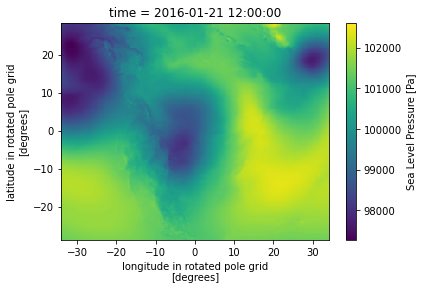

In [4]:
P_world.psl[20,:,:].plot()
#plt.savefig('RCMdata.png')

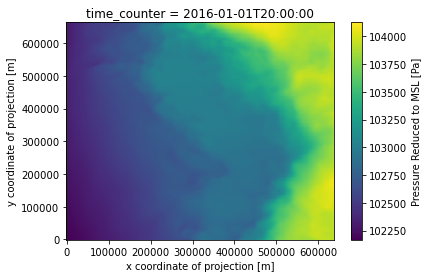

In [5]:
hrdps.atmpres[20,:,:].plot()
#plt.savefig('HRDPSdata.png')

In [6]:
#next we want the HRDPS data to be daily instead of hourly
hrdps = hrdps.resample(time_counter='D').mean(dim='time_counter')

In [7]:
#find index of extra day (leap day)
ind = list(hrdps.time_counter.values).index(np.datetime64('2016-02-29T00:00:00.000000000'))

In [8]:
#and then trim the components you want to work with to be in a more relevant extent 
#(dont need the HRDPS data to stretch as far as it does inland)
p_temp = np.concatenate((hrdps.atmpres.sel(x=slice(0., 480000.)).values[0:ind,:,:], hrdps.atmpres.sel(x=slice(0., 480000.)).values[(ind+1):,:,:]))
hrdps_lat = hrdps.nav_lat.sel(x=slice(0., 480000.)).values
hrdps_lon = hrdps.nav_lon.sel(x=slice(0., 480000.)).values

In [9]:
#now extract the lat, lon, U, and V and get into form that I can work with
hrdps_lat = hrdps_lat[0,:,:].flatten()
hrdps_lon = hrdps_lon[0,:,:].flatten()

In [10]:
#slp to 2D - space is the m component in my research question not time
P_hrdps = np.empty((np.shape(p_temp)[1]*np.shape(p_temp)[2],np.shape(p_temp)[0]))
for i in range(np.shape(p_temp)[0]):
    P_hrdps[:,i] = np.reshape(p_temp[i],(np.shape(p_temp)[1]*np.shape(p_temp)[2],))

In [11]:
#replace all nan with atmospheric pressure (101325 Pa)
P_hrdps = (pd.DataFrame(P_hrdps).fillna(101325)).to_numpy() 

#normalize the data
#P_hrdps = (P_hrdps - P_hrdps.mean())/P_hrdps.std()

In [12]:
#trim the world dataset to be for right time extent
#want days between June 1 2018 and June 30 2018
P_world = P_world.sel(time=slice('2016-01-01 12:00:00', '2019-12-31 12:00:00')) #model does not do leap day so don't load in leap day from hrdps
#P_world = P_world.sel(time=slice('2016-01-01 12:00:00', '2016-12-31 12:00:00'))

In [13]:
#now extract the data you want from the CanRCM4 xarray and trim them according to lat and lon of the HRDPS data
#first decide on range you want to work within for CanRCM4 data, want to overlap the HRDPS data by 10% of the max distance (y)
buffer = (max(hrdps_lat)-min(hrdps_lat))*0.1

lon = P_world.lon.values.flatten()
lat = P_world.lat.values.flatten()
index = []

#first find idexes that fit into lon range and lat range
for i in range(len(lon)):
    if lon[i] > (min(hrdps_lon)-buffer) and lon[i] < (max(hrdps_lon)+buffer) and lat[i] > (min(hrdps_lat)-buffer) and lat[i] < (max(hrdps_lat)+buffer):
        index.append(i)

#now make new lat, and lon
lat_RCM = []
lon_RCM = []

for i in index:
    lat_RCM.append(lat[i])
    lon_RCM.append(lon[i])

In [14]:
#now convert data to 2D and use the idices found in the previous step to trim it
P2d = np.empty((np.shape(P_world.psl.values)[1]*np.shape(P_world.psl.values)[2],np.shape(P_world.psl.values)[0]))
for i in range(np.shape(P_world.psl.values)[0]):
    P2d[:,i] = np.reshape(P_world.psl.values[i],(np.shape(P_world.psl.values)[1]*np.shape(P_world.psl.values)[2],))

P_RCM = np.empty((len(index),np.shape(P_world.psl.values)[0]))

for i in range(np.shape(P_hrdps)[1]):
    for j in range(len(index)):
        P_RCM[j,i] = P2d[index[j],i]

In [15]:
#normalize the data
#P_RCM = (P_RCM - P_RCM.mean())/P_RCM.std()

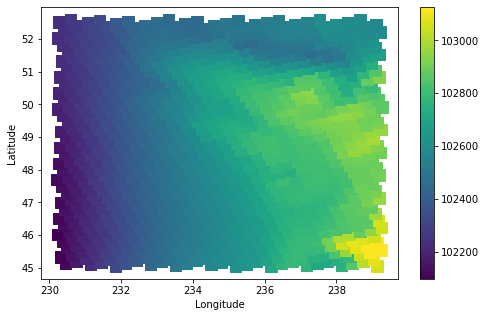

In [16]:
#visualize preprocessing
plt.figure(figsize=(8,5))

plt.scatter(lon_RCM, lat_RCM,
            c = P_RCM[:,0],
            cmap = 'viridis',
            s = 133,
            marker = 's')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar()

## PCA 
First on CanRCM4 Model

In [17]:
#PCA on the world data
#looking for dominant spatial patterns to be eigenvectors and how those spatial patterns evelove over the month to the the PCs)
#need to take the transpose of the matrix 

data = P_RCM.T

n_modes = np.min(np.shape(data))
pca = PCA(n_components = n_modes)
RCM_PCs = pca.fit_transform(data)
RCM_eigvecs = pca.components_
RMCfracVar = pca.explained_variance_ratio_

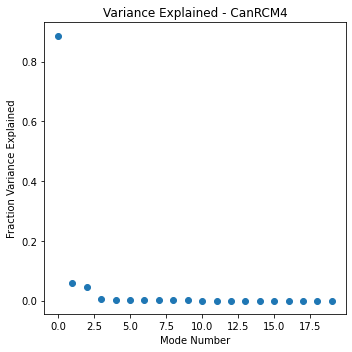

In [18]:
#plot fraction of variance explained by each mode

plt.figure(figsize=(5,5))

plt.scatter(range(len(RMCfracVar[0:20])),RMCfracVar[0:20])
plt.xlabel('Mode Number')
plt.ylabel('Fraction Variance Explained')
plt.title('Variance Explained - CanRCM4')

plt.tight_layout()

plt.show()

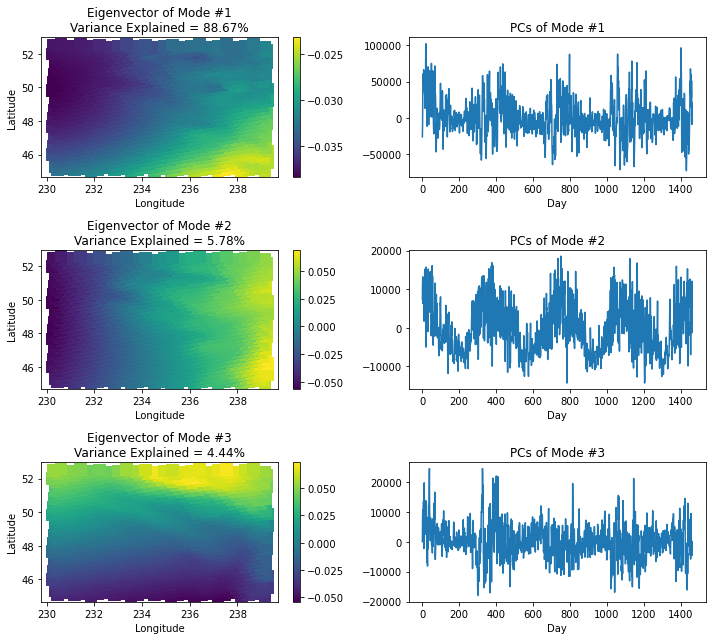

In [19]:
#keep first three modes
#visualise P component
n = 3
day1 = 1
dayfinal = len(data)

plt.figure(figsize=(10,3*n))
for kk in range(n):
    
    plt.subplot(n,2,kk*2+1)
    plt.scatter(lon_RCM, lat_RCM,
            c = RCM_eigvecs[kk,:],
            cmap = 'viridis',
            s = 133,
            marker = 's')
    plt.title('Eigenvector of Mode #' + str(kk+1) +'\nVariance Explained = ' +str(round(RMCfracVar[kk]*100,2))+ '%')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.colorbar()
    
    plt.subplot(n,2,(kk+1)*2)
    plt.plot(range(day1,dayfinal+1),RCM_PCs[:,kk])
    plt.title('PCs of Mode #' + str(kk+1))
    plt.xlabel('Day')
    
    plt.tight_layout()
    
#plt.savefig('PCA-RCM-P.png')

Now on the HRDPS Data

In [20]:
#PCA on the HRDPS data 
data = P_hrdps.T

n_modes = np.min(np.shape(data))
pca = PCA(n_components = n_modes)
hrdps_PCs = pca.fit_transform(data)
hrdps_eigvecs = pca.components_
hrdps_fracVar = pca.explained_variance_ratio_

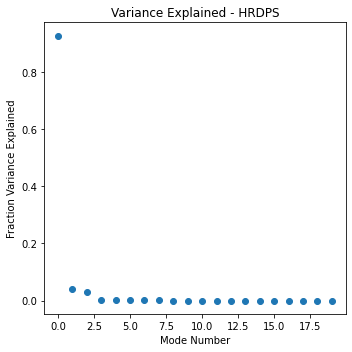

In [21]:
#plot fraction of variance explained by each mode

plt.figure(figsize=(5,5))

plt.scatter(range(len(hrdps_fracVar[0:20])),hrdps_fracVar[0:20]) #plot only first 20
plt.xlabel('Mode Number')
plt.ylabel('Fraction Variance Explained')
plt.title('Variance Explained - HRDPS')

plt.tight_layout()

plt.show()

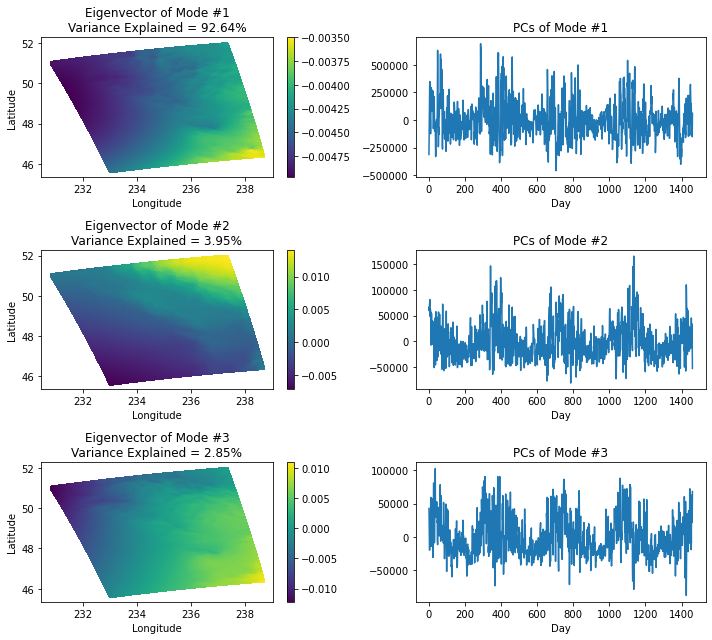

In [22]:
#keep first mode
#visualise
n = 3

plt.figure(figsize=(10,3*n))
for kk in range(n):
    
    plt.subplot(n,2,kk*2+1)
    plt.scatter(hrdps_lon, hrdps_lat,
            c = hrdps_eigvecs[kk,:],
            cmap = 'viridis',
            s = 10,
            marker = 's')
    plt.title('Eigenvector of Mode #' + str(kk+1) +'\nVariance Explained = ' +str(round(hrdps_fracVar[kk]*100,2))+ '%')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.colorbar()
    
    plt.subplot(n,2,(kk+1)*2)
    plt.plot(range(day1,dayfinal+1),hrdps_PCs[:,kk])
    plt.title('PCs of Mode #' + str(kk+1))
    plt.xlabel('Day')
    
    plt.tight_layout()

#plt.savefig('PCA-HRDPS-U.png')

## Linear Regression

In [17]:
#NOTE: stepwise_selection function used (and modified) from: 
#https://datascience.stackexchange.com/questions/24405/how-to-do-stepwise-regression-using-sklearn/24447#24447

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.argmin()
            included.append(excluded[best_feature])
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(excluded[best_feature], best_pval))
        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

{'tags': ['hide-input']}

In [76]:
#see if we can model PC1 of HRDPS using first 3 PCs of CanRCM4

x = RCM_PCs[:,:3] #CanRCM4 PCAs as x
y = hrdps_PCs[:,:1] #HRDPS PCAs as y

#normalise them first
xmax = np.max(x,axis=0)
xmin = np.min(x,axis=0)
ymax = np.max(y,axis=0)
ymin = np.min(y,axis=0)

x-=xmin
x/=(xmax-xmin)
y-=ymin
y/=(ymax-ymin)

In [74]:
#now, use stepwise regression to find which predictors to use
x = pd.DataFrame(x)
y = pd.DataFrame(y)


result = stepwise_selection(x, y)

print('resulting features:'+ str(result))

Add                               0 with p-value 8.09422e-05
resulting features:[0]


<ipython-input-22-2ec019a30e10>:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)
<ipython-input-22-2ec019a30e10>:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


In [75]:
#apply MLR on X and Y

lm_MLR = linear_model.LinearRegression()
model = lm_MLR.fit(x[result],y)
ypred_MLR = lm_MLR.predict(x[result]) #y predicted by MLR
intercept_MLR = lm_MLR.intercept_ #intercept predicted by MLR
coef_MLR = lm_MLR.coef_ #regression coefficients in MLR model
R2_MLR = lm_MLR.score(x[result],y) #R-squared value from MLR model

print('MLR results:')
print('a0 = ' + str(intercept_MLR))
print('a1 = ' + str(coef_MLR[0]))
# print('a2 = ' + str(coef_MLR[1]))
# print('a3 = ' + str(coef_MLR[2]))
# print('a4 = ' + str(coef_MLR[3]))
print("R^2 =" + str(R2_MLR))

MLR results:
a0 = [0.26537228]
a1 = [0.20376789]
R^2 =0.0419526812503771


Text(0.5, 1.0, 'MLR, R^2 = 0.0419526812503771')

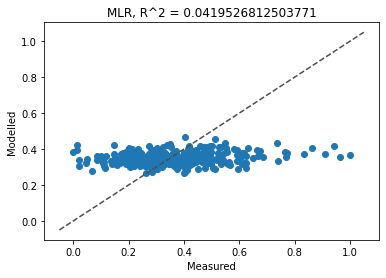

In [45]:
#plot MLR results alone

ax1 = plt.subplot(111)
ax1.scatter(y,ypred_MLR)
l1 = np.min(ax1.get_xlim())
l2 = np.max(ax1.get_xlim())
ax1.plot([l1,l2], [l1,l2], ls="--", c=".3")
plt.xlabel('Measured')
plt.ylabel('Modelled')
plt.title('MLR, R^2 = ' + str(R2_MLR))


These results are similar to what we see when applying MLP NN - reconstruction very bad at modelling 'extreme' values.

## Correlation Analysis

OKKKKKKK lets see how well dominant PCs of both datasets corelate with eachother in time - maybe this way we can see if lagging helps <br>

Don't think CCA is the right choice for this analysis, just calc R^2 values between PCs of same mode 

In [159]:
x = RCM_PCs[:,:3] #CanRCM4 PCAs as x
y = hrdps_PCs[:,:3] #HRDPS PCAs as y

#normalise them first
xmax = np.max(x,axis=0)
xmin = np.min(x,axis=0)
ymax = np.max(y,axis=0)
ymin = np.min(y,axis=0)

x-=xmin
x/=(xmax-xmin)
y-=ymin
y/=(ymax-ymin)

#calc r value
n_modes = 3 #modes to keep
r = [np.corrcoef(x[:,ii],y[:,ii]) for ii in range(n_modes)]

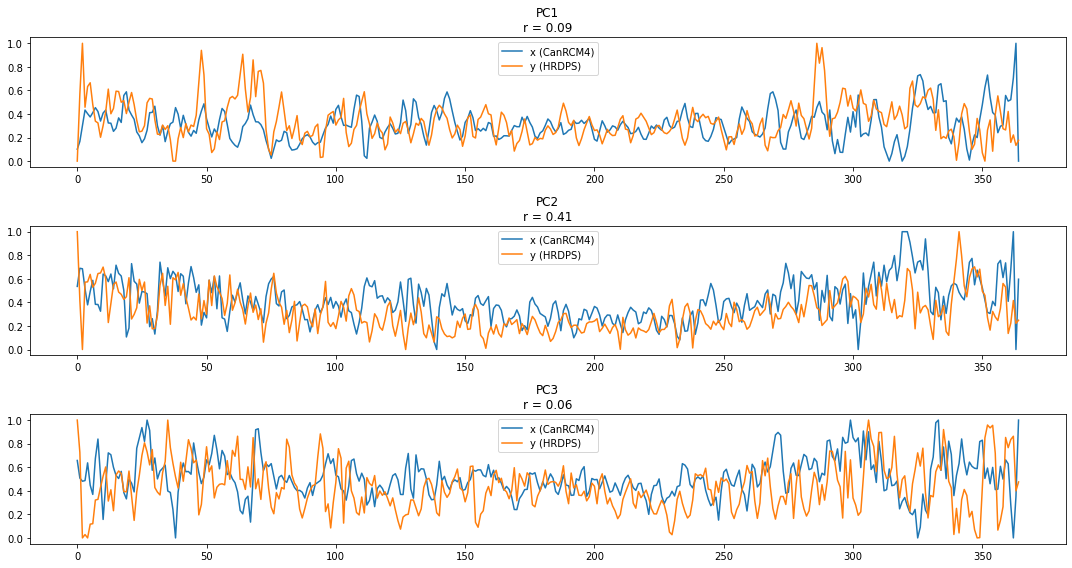

In [164]:
plt.figure(figsize=(15,8))

plt.subplot(3,1,1)
plt.plot(x[:,0])
plt.plot(y[:,0])
plt.legend(['x (CanRCM4)','y (HRDPS)'])
plt.title('PC1\nr = ' + str(r[0][0,1])[:4])

plt.subplot(3,1,2)
plt.plot(x[:,1])
plt.plot(y[:,1])
plt.legend(['x (CanRCM4)','y (HRDPS)'])
plt.title('PC2\nr = ' + str(r[1][0,1])[:4])

plt.subplot(3,1,3)
plt.plot(x[:,2])
plt.plot(y[:,2])
plt.legend(['x (CanRCM4)','y (HRDPS)'])
plt.title('PC3\nr = ' + str(r[2][0,1])[:4])

plt.tight_layout()

[[1.         0.11207418]
 [0.11207418 1.        ]]


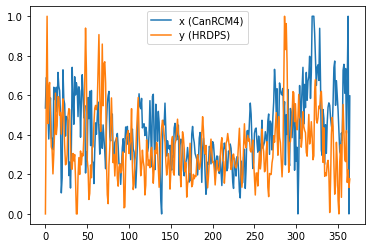

In [162]:
plt.plot(x[:,1])
plt.plot(y[:,0])
plt.legend(['x (CanRCM4)','y (HRDPS)'])
#plt.title('PC3\nr = ' + str(r[2][0,1])[:4])
print(np.corrcoef(x[:,1],y[:,0]))

[[1.         0.04733313]
 [0.04733313 1.        ]]


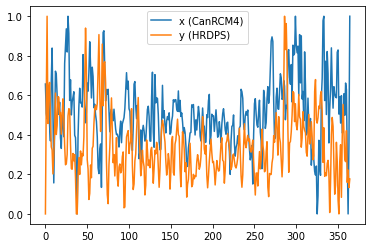

In [163]:
#try different PCs of CanrCM4 with PC1 of HRDPS
plt.plot(x[:,2])
plt.plot(y[:,0])
plt.legend(['x (CanRCM4)','y (HRDPS)'])
#plt.title('PC3\nr = ' + str(r[2][0,1])[:4])
print(np.corrcoef(x[:,2],y[:,0]))

Ok so we care the most about the PC1s being similar, so try lagging the CanRCM4 data so that r for this increases (potentially at the expence of PC2 and PC3 correlation). 

In [150]:
#do correlation on lagged dataset
#first shift CanRMC4 backwards (ex. June 3 of CanRCM4 aligns with June 1 of HRDPS)
r = []

for shift in range(100):
    shift += 1
    x = RCM_PCs[shift:,:1] #need to trim beginning of x by amount you want to shift
    y = hrdps_PCs[:-shift,:1] #need to trim end of y by ammount CanRCM4 is shifted backwards

    #normalise them first
    xmax = np.max(x,axis=0)
    xmin = np.min(x,axis=0)
    ymax = np.max(y,axis=0)
    ymin = np.min(y,axis=0)

    x-=xmin
    x/=(xmax-xmin)
    y-=ymin
    y/=(ymax-ymin)

    n_modes = 3 #modes to keep
    r.append(np.corrcoef(x[:,0],y[:,0])[0,1])

print('Correlation after lagging by ' + str(r.index(max(r))+1) + ' day(s): r=' + str(max(r)))

# plt.plot(x[:,0])
# plt.plot(y[:,0])
# plt.legend(['x (CanRCM4)','y (HRDPS)'])
# plt.title('PC1\nr = ' + str(r[0][0,1])[:4])

Correlation after lagging by 37 day(s): r=0.3140206319197593


In [151]:
#do correlation on lagged dataset
#first shift CanRMC4 forwards (ex. June 1 of CanRCM4 aligns with June 3 of HRDPS)
r = []

for shift in range(100):
    shift += 1
    x = RCM_PCs[:-shift,:1] #need to trim end of x by ammount CanRCM4 is shifted
    y = hrdps_PCs[shift:,:1] #need to trim beginning of y by amount you want to shift

    #normalise them first
    xmax = np.max(x,axis=0)
    xmin = np.min(x,axis=0)
    ymax = np.max(y,axis=0)
    ymin = np.min(y,axis=0)

    x-=xmin
    x/=(xmax-xmin)
    y-=ymin
    y/=(ymax-ymin)

    n_modes = 3 #modes to keep
    r.append(np.corrcoef(x[:,0],y[:,0])[0,1])

print('Correlation after lagging by ' + str(r.index(max(r))+1) + ' day(s): r=' + str(max(r)))

# plt.plot(x[:,0])
# plt.plot(y[:,0])
# plt.legend(['x (CanRCM4)','y (HRDPS)'])
# plt.title('PC1\nr = ' + str(r[0][0,1])[:4])

Correlation after lagging by 1 day(s): r=0.1883689693404432


In [148]:
#Lagging forward by 37 days yielded the best results
shift = 37

x = RCM_PCs[shift:,:3] #need to trim beginning of x by amount you want to shift
y = hrdps_PCs[:-shift,:3] #need to trim end of y by ammount CanRCM4 is shifted backwards

#normalise them first
xmax = np.max(x,axis=0)
xmin = np.min(x,axis=0)
ymax = np.max(y,axis=0)
ymin = np.min(y,axis=0)

x-=xmin
x/=(xmax-xmin)
y-=ymin
y/=(ymax-ymin)

#calc r value of all three modes
n_modes = 3 #modes to keep
r = [np.corrcoef(x[:,ii],y[:,ii]) for ii in range(n_modes)]

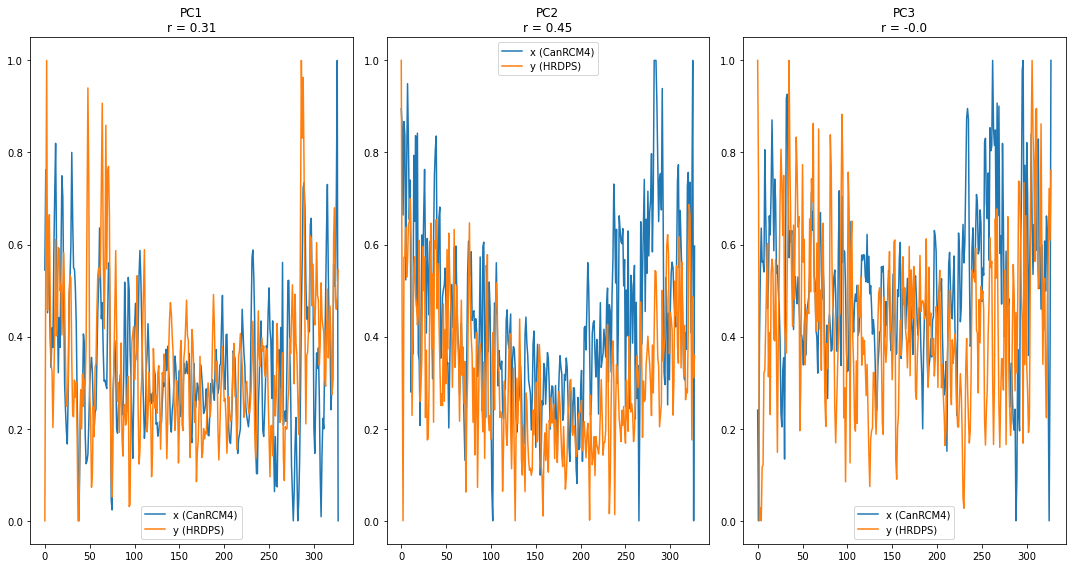

In [149]:
plt.figure(figsize=(15,8))

plt.subplot(1,3,1)
plt.plot(x[:,0])
plt.plot(y[:,0])
plt.legend(['x (CanRCM4)','y (HRDPS)'])
plt.title('PC1\nr = ' + str(r[0][0,1])[:4])

plt.subplot(1,3,2)
plt.plot(x[:,1])
plt.plot(y[:,1])
plt.legend(['x (CanRCM4)','y (HRDPS)'])
plt.title('PC2\nr = ' + str(r[1][0,1])[:4])

plt.subplot(1,3,3)
plt.plot(x[:,2])
plt.plot(y[:,2])
plt.legend(['x (CanRCM4)','y (HRDPS)'])
plt.title('PC3\nr = ' + str(r[2][0,1])[:4])

plt.tight_layout()

Better matching with 37 day lag but only keep PC1 and PC2 <br>
But this isn't a physically reasonable lag AND the PCs still dont even match that well

## Variance Analysis
looking at how the total variance in the winter months varies from year to year and between datasets

In [23]:
#Select and normalize data first

x = RCM_PCs[:,:3] #CanRCM4 PCAs as x
y = hrdps_PCs[:,:3] #HRDPS PCAs as y

#normalise them first
xmax = np.max(x,axis=0)
xmin = np.min(x,axis=0)
ymax = np.max(y,axis=0)
ymin = np.min(y,axis=0)

x-=xmin
x/=(xmax-xmin)
y-=ymin
y/=(ymax-ymin)

In [24]:
#split datasets into different arrays for winter 2016/2017, 2017/2018, 2018/2019
#set 'winter' in Canada as October 1 - March 31

octo = 274 -1 #october 1 is the 274th day of the year (so ind 273)
mar = 365 + 90 - 1 #march 31 is the 90th day of the following year

WinterRCM = np.empty([9,(mar-octo)]) #one array for each dataset (first three rows are top three PCs for first winter ans so on)
WinterHRDPS = np.empty([9,(mar-octo)])

for i in range(3):
    for j in range(mar-octo):
        WinterRCM[i,j] = x[octo+(i*365)+j,0]
        WinterRCM[i+1,j] = x[octo+(i*365)+j,1]
        WinterRCM[i+2,j] = x[octo+(i*365)+j,2]
        WinterHRDPS[i,j] = y[octo+(i*365)+j,0]
        WinterHRDPS[i+1,j] = y[octo+(i*365)+j,1]
        WinterHRDPS[i+2,j] = y[octo+(i*365)+j,2]

In [25]:
#get variance of each year
def var(data, ddof=0):
    n = len(data)
    mean = sum(data) / n
    return sum((x - mean) ** 2 for x in data) / (n - ddof)
    
varRCM = np.empty([3,3])
varHRDPS = np.empty([3,3])

for i in range(3):
    varRCM[i,0]=var(WinterRCM[0+i,:]) #each row is one year with each column being another PC
    varRCM[i,1]=var(WinterRCM[1+i,:])
    varRCM[i,2]=var(WinterRCM[2+i,:])
    varHRDPS[i,0]=var(WinterHRDPS[0+i,:])
    varHRDPS[i,1]=var(WinterHRDPS[1+i,:])
    varHRDPS[i,2]=var(WinterHRDPS[2+i,:])

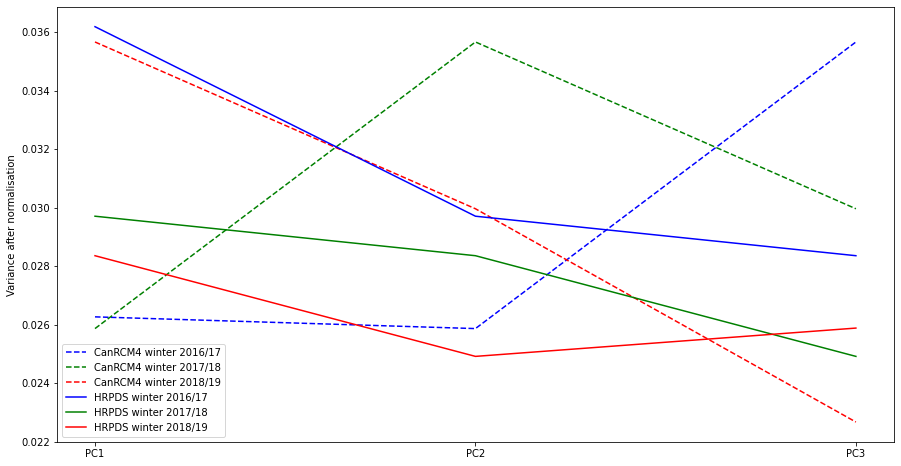

In [28]:
plt.figure(figsize=(15,8))

plt.plot(varRCM[0,:], label='CanRCM4 winter 2016/17',c='b',ls='--')
plt.plot(varRCM[1,:], label='CanRCM4 winter 2017/18',c='g',ls='--')
plt.plot(varRCM[2,:], label='CanRCM4 winter 2018/19',c='r',ls='--')
plt.plot(varHRDPS[0,:], label='HRPDS winter 2016/17',c='b')
plt.plot(varHRDPS[1,:], label='HRPDS winter 2017/18',c='g')
plt.plot(varHRDPS[2,:], label='HRPDS winter 2018/19',c='r')
plt.ylabel('Variance after normalisation')
plt.xticks([0,1,2],['PC1','PC2','PC3'])
plt.legend()

## Grid-search optimization

In [152]:
#define RMSE as a function
def rmse(target,prediction):
    return(np.sqrt(((target - prediction)**2).sum()/len(target)))

Making a seperate NN for each HRDPS PC (use two at first and then analyse difference of just using 1)

In [153]:
#set training and validation data - for 1st HRDPS PC
#recall that we chose 3 PCs for RCM model u-component and 3 PCs for HRDPS u-component
nPCs_RCM = 2
nPCs_hrdps = 1

x = RCM_PCs[shift:,:nPCs_RCM] #CanRCM4 PCAs as input
y = np.squeeze(hrdps_PCs[:-shift,:nPCs_hrdps]) #HRDPS PCAs as output

Ntrain = int(len(y)*0.8) #take 80% of the total data to be for training
x_train = x[:Ntrain]
y_train = y[:Ntrain]
x_test = x[Ntrain:]
y_test = y[Ntrain:]

#unit based normalization wrt training set
xmax = np.max(x_train,axis=0)
xmin = np.min(x_train,axis=0)
ymax = np.max(y_train,axis=0)
ymin = np.min(y_train,axis=0)

x_train-=xmin
x_train/=(xmax-xmin)
x_test-=xmin
x_test/=(xmax-xmin)
y_train-=ymin
y_train/=(ymax-ymin)
y_test-=ymin
y_test/=(ymax-ymin)

In [154]:
#This chunk of code is relatively flexible and can be used to loop through a range of parameters
#We'll use this code several different times in the notebook
#Play around and see what kinds of models you can make

##### Play around with these parameters
num_models = 20 #number of models to build for the ensemble
min_nhn = 1 #minimum number of hidden neurons to loop through (nhn = 'number hidden neurons')
max_nhn = 243 #maximum number of hidden neurons to loop through
max_hidden_layers = 2 #maximum number of hidden layers to loop through (nhl = 'number hidden layers')
batch_size = 32
solver = 'sgd' #use stochastic gradient descent as an optimization method (weight updating algorithm)
activation = 'relu'
learning_rate_init = 0.01
max_iter = 2000 #max number of epochs to run for any model
early_stopping = True #True = stop early if validation error begins to rise
validation_fraction = 0.2 #fraction of training data to use as validation
#####

y_out_all_nhn = []
bestmodels = []
y_out_ensemble = []
RMSE_ensemble = [] #RMSE for each model in the ensemble
RMSE_ensemble_cumsum = [] #RMSE of the cumulative saltation for each model
nhn_best = []
nhl_best = []

for model_num in range(num_models): #for each model in the ensemble
    
    print('Model Number: ' + str(model_num))
    
    models = []
    RMSE = []
    y_out_all_nhn = []
    nhn = []
    nhl = []
    
    for num_hidden_layers in range(1,max_hidden_layers+1):
    
        #print('\t # Hidden Layers = ' + str(num_hidden_layers))
    
        for num_hidden_neurons in range(min_nhn,max_nhn+1): #for each number of hidden neurons

            #print('\t\t # hidden neurons = ' + str(num_hidden_neurons))
            
            hidden_layer_sizes = (num_hidden_neurons,num_hidden_layers)
            model = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, 
                                 verbose=False,
                                 max_iter=max_iter, 
                                 early_stopping = early_stopping,
                                 validation_fraction = validation_fraction,
                                 batch_size = batch_size,
                                 solver = solver,
                                 activation = activation,
                                 learning_rate_init = learning_rate_init)

            model.fit(x_train,y_train) #train the model
            models.append(model) #add the models to list to be accessed later

            y_out_this_nhn = model.predict(x_test) #model prediction for this number of hidden neurons (nhn)
            y_out_all_nhn.append(y_out_this_nhn) #store all models -- will select best one best on RMSE
            
            #now export the models from each run

            RMSE.append(rmse(y_test,y_out_this_nhn)) #RMSE of this model
            
            nhn.append(num_hidden_neurons)
            nhl.append(num_hidden_layers)
        
    indBest = RMSE.index(np.min(RMSE)) #index of model with lowest RMSE
    RMSE_ensemble.append(np.min(RMSE))
    nhn_best.append(nhn[indBest])
    nhl_best.append(nhl[indBest])
    #nhn_best.append(indBest+1) #the number of hidden neurons that achieved best model performance of this model iteration
    y_out_ensemble.append(y_out_all_nhn[indBest])
    bestmodels.append(models[indBest]) #only save the models that worked the best
    
    print('\t BEST: ' + str(nhl_best[model_num]) + ' hidden layers, '+ str(nhn_best[model_num]) + ' hidden neurons')
    
y_out_ensemble_mean = np.mean(y_out_ensemble,axis=0)
RMSE_ensemble_mean = rmse(y_out_ensemble_mean,y_test)

Model Number: 0
	 BEST: 2 hidden layers, 100 hidden neurons
Model Number: 1
	 BEST: 2 hidden layers, 117 hidden neurons
Model Number: 2
	 BEST: 2 hidden layers, 234 hidden neurons
Model Number: 3
	 BEST: 2 hidden layers, 176 hidden neurons
Model Number: 4
	 BEST: 2 hidden layers, 78 hidden neurons
Model Number: 5
	 BEST: 1 hidden layers, 151 hidden neurons
Model Number: 6
	 BEST: 1 hidden layers, 155 hidden neurons
Model Number: 7
	 BEST: 2 hidden layers, 207 hidden neurons
Model Number: 8
	 BEST: 1 hidden layers, 131 hidden neurons
Model Number: 9
	 BEST: 1 hidden layers, 184 hidden neurons
Model Number: 10
	 BEST: 1 hidden layers, 133 hidden neurons
Model Number: 11
	 BEST: 2 hidden layers, 62 hidden neurons
Model Number: 12
	 BEST: 1 hidden layers, 216 hidden neurons
Model Number: 13
	 BEST: 2 hidden layers, 182 hidden neurons
Model Number: 14
	 BEST: 2 hidden layers, 76 hidden neurons
Model Number: 15
	 BEST: 1 hidden layers, 82 hidden neurons
Model Number: 16
	 BEST: 1 hidden laye

In [155]:
# therefore based on this grid-search optimization pick model with lowest RMSE for the reconstruction
PC1model = bestmodels[RMSE_ensemble.index(min(RMSE_ensemble))]
print(PC1model)

MLPRegressor(batch_size=32, early_stopping=True, hidden_layer_sizes=(117, 2),
             learning_rate_init=0.01, max_iter=2000, solver='sgd',
             validation_fraction=0.2)


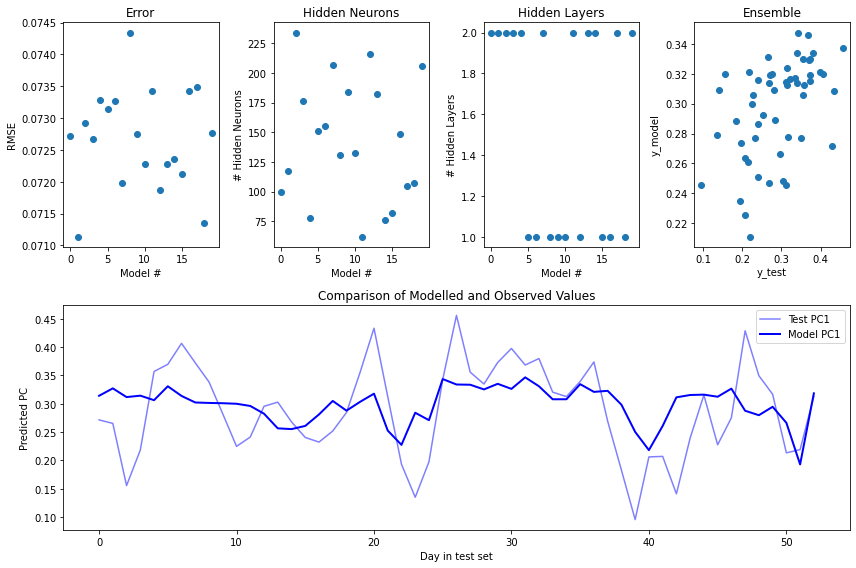

In [156]:
#visualize

plt.figure(figsize=(12,8))

plt.subplot(241)
#plt.scatter(len(RMSE_ensemble),RMSE_ensemble_mean,c='k',marker='*')
plt.scatter(range(len(RMSE_ensemble)),RMSE_ensemble)
plt.xlabel('Model #')
plt.ylabel('RMSE')
plt.title('Error')

plt.subplot(242)
plt.scatter(range(len(nhn_best)),nhn_best)
plt.xlabel('Model #')
plt.ylabel('# Hidden Neurons')
plt.title('Hidden Neurons')

plt.subplot(243)
plt.scatter(range(len(nhl_best)),nhl_best)
plt.xlabel('Model #')
plt.ylabel('# Hidden Layers')
plt.title('Hidden Layers')

plt.subplot(244)
plt.scatter(y_test,y_out_ensemble_mean)
#plt.plot((np.min(y_test),np.max(y_test)),'k--')
plt.xlabel('y_test')
plt.ylabel('y_model')
plt.title('Ensemble')

plt.subplot(212)
plt.plot(y_test,alpha=0.5, label='Test PC1', c='b')
# plt.plot(y_test[:,1],alpha=0.5, label='Test PC2', c='g')
# plt.plot(y_test[:,2],alpha=0.5, label='Test PC3', c='r')
plt.plot(PC1model.predict(x_test), label='Model PC1', c='b', lw=2)
# plt.plot(PC1model.predict(x_test)[:,1], label='Model PC2', c='g', lw=2)
# plt.plot(PC1model.predict(x_test)[:,2], label='Model PC3', c='r', lw=2)
# plt.plot(y_out_ensemble_mean[:,0], label='Model PC1', c='b', lw=2)
# plt.plot(y_out_ensemble_mean[:,1], label='Model PC2', c='g', lw=2)
# plt.plot(y_out_ensemble_mean[:,2], label='Model PC3', c='r', lw=2)
plt.legend()
plt.xlabel('Day in test set')
plt.ylabel('Predicted PC')
plt.title('Comparison of Modelled and Observed Values')

plt.tight_layout()

In [157]:
#set training and validation data - for 2nd HRDPS PC
#recall that we chose 3 PCs for RCM model u-component and 3 PCs for HRDPS u-component
#NOTE: we only need to reset output (y)

nPCs_hrdps = 2

y = np.squeeze(hrdps_PCs[:,(nPCs_hrdps-1):nPCs_hrdps]) #HRDPS PCAs as output

Ntrain = int(len(y)*0.8) #take 80% of the total data to be for training
y_train = y[:Ntrain]
y_test = y[Ntrain:]

#unit based normalization wrt training set
ymax = np.max(y_train,axis=0)
ymin = np.min(y_train,axis=0)

y_train-=ymin
y_train/=(ymax-ymin)
y_test-=ymin
y_test/=(ymax-ymin)

In [158]:
#This chunk of code is relatively flexible and can be used to loop through a range of parameters
#We'll use this code several different times in the notebook
#Play around and see what kinds of models you can make

##### Play around with these parameters
num_models = 20 #number of models to build for the ensemble
min_nhn = 1 #minimum number of hidden neurons to loop through (nhn = 'number hidden neurons')
max_nhn = 243 #maximum number of hidden neurons to loop through
max_hidden_layers = 2 #maximum number of hidden layers to loop through (nhl = 'number hidden layers')
batch_size = 32
solver = 'sgd' #use stochastic gradient descent as an optimization method (weight updating algorithm)
activation = 'relu'
learning_rate_init = 0.01
max_iter = 2000 #max number of epochs to run for any model
early_stopping = True #True = stop early if validation error begins to rise
validation_fraction = 0.2 #fraction of training data to use as validation
#####

y_out_all_nhn = []
bestmodels = []
y_out_ensemble = []
RMSE_ensemble = [] #RMSE for each model in the ensemble
RMSE_ensemble_cumsum = [] #RMSE of the cumulative saltation for each model
nhn_best = []
nhl_best = []

for model_num in range(num_models): #for each model in the ensemble
    
    print('Model Number: ' + str(model_num))
    
    models = []
    RMSE = []
    y_out_all_nhn = []
    nhn = []
    nhl = []
    
    for num_hidden_layers in range(1,max_hidden_layers+1):
    
        #print('\t # Hidden Layers = ' + str(num_hidden_layers))
    
        for num_hidden_neurons in range(min_nhn,max_nhn+1): #for each number of hidden neurons

            #print('\t\t # hidden neurons = ' + str(num_hidden_neurons))
            
            hidden_layer_sizes = (num_hidden_neurons,num_hidden_layers)
            model = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, 
                                 verbose=False,
                                 max_iter=max_iter, 
                                 early_stopping = early_stopping,
                                 validation_fraction = validation_fraction,
                                 batch_size = batch_size,
                                 solver = solver,
                                 activation = activation,
                                 learning_rate_init = learning_rate_init)

            model.fit(x_train,y_train) #train the model
            models.append(model) #add the models to list to be accessed later

            y_out_this_nhn = model.predict(x_test) #model prediction for this number of hidden neurons (nhn)
            y_out_all_nhn.append(y_out_this_nhn) #store all models -- will select best one best on RMSE
            
            #now export the models from each run

            RMSE.append(rmse(y_test,y_out_this_nhn)) #RMSE of this model
            
            nhn.append(num_hidden_neurons)
            nhl.append(num_hidden_layers)
        
    indBest = RMSE.index(np.min(RMSE)) #index of model with lowest RMSE
    RMSE_ensemble.append(np.min(RMSE))
    nhn_best.append(nhn[indBest])
    nhl_best.append(nhl[indBest])
    #nhn_best.append(indBest+1) #the number of hidden neurons that achieved best model performance of this model iteration
    y_out_ensemble.append(y_out_all_nhn[indBest])
    bestmodels.append(models[indBest]) #only save the models that worked the best
    
    print('\t BEST: ' + str(nhl_best[model_num]) + ' hidden layers, '+ str(nhn_best[model_num]) + ' hidden neurons')
    
y_out_ensemble_mean = np.mean(y_out_ensemble,axis=0)
RMSE_ensemble_mean = rmse(y_out_ensemble_mean,y_test)

Model Number: 0


ValueError: Found input variables with inconsistent numbers of samples: [212, 292]

In [ ]:
# therefore based on this grid-search optimization pick model with lowest RMSE for the reconstruction
PC2model = bestmodels[RMSE_ensemble.index(min(RMSE_ensemble))]
print(PC2model)

In [ ]:
#visualize

plt.figure(figsize=(12,8))

plt.subplot(241)
#plt.scatter(len(RMSE_ensemble),RMSE_ensemble_mean,c='k',marker='*')
plt.scatter(range(len(RMSE_ensemble)),RMSE_ensemble)
plt.xlabel('Model #')
plt.ylabel('RMSE')
plt.title('Error')

plt.subplot(242)
plt.scatter(range(len(nhn_best)),nhn_best)
plt.xlabel('Model #')
plt.ylabel('# Hidden Neurons')
plt.title('Hidden Neurons')

plt.subplot(243)
plt.scatter(range(len(nhl_best)),nhl_best)
plt.xlabel('Model #')
plt.ylabel('# Hidden Layers')
plt.title('Hidden Layers')

plt.subplot(244)
plt.scatter(y_test,y_out_ensemble_mean)
#plt.plot((np.min(y_test),np.max(y_test)),'k--')
plt.xlabel('y_test')
plt.ylabel('y_model')
plt.title('Ensemble')

plt.subplot(212)
plt.plot(y_test,alpha=0.5, label='Test PC1', c='g')
plt.plot(PC1model.predict(x_test), label='Model PC1', c='g', lw=2)
plt.legend()
plt.xlabel('Day in test set')
plt.ylabel('Predicted PC')
plt.title('Comparison of Modelled and Observed Values')

plt.tight_layout()

In [ ]:
# plt.figure(figsize=(12,8))


# plt.subplot(311)
# plt.plot(y[:,0],alpha=0.2, label='PC1', c='b')
# plt.plot(model.predict(x)[:,0], label='Model PC1', c='b', lw=2)
# plt.legend()
# plt.ylabel('Predicted PC')
# plt.title('Comparison of Modelled and Observed Values')

# plt.subplot(312)
# plt.plot(y[:,1],alpha=0.2, label='PC2', c='g')
# plt.plot(model.predict(x)[:,1], label='Model PC2', c='g', lw=2)
# plt.legend()
# plt.ylabel('Predicted PC')

# plt.subplot(313)
# plt.plot(y[:,2],alpha=0.2, label='PC3', c='r')
# plt.plot(model.predict(x)[:,2], label='Model PC3', c='r', lw=2)
# plt.legend()
# plt.xlabel('Day in test set')
# plt.ylabel('Predicted PC')

## Future prediction and reconstruction

In [79]:
#reconstruct - with model PCs

PCs = model.predict(x)
#PCs = PCs*(xmax-xmin)+xmin


numObs = np.shape(hrdps_eigvecs)[0]-1
data_rec = np.empty([numObs,np.shape(hrdps_eigvecs)[1]])
for kk in range(numObs): #for each time step
    this_rec = np.zeros([1,np.shape(hrdps_eigvecs)[1]])
    for mode in range(3): #range is number of modes we kept
        this_rec += hrdps_eigvecs[mode,:]*PCs[kk,mode]    
    data_rec[kk,:] = this_rec

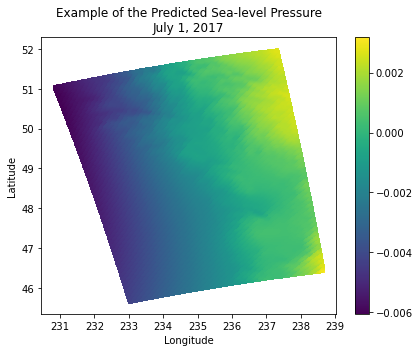

In [80]:
#visualize reconstruction - with model PCs
plt.figure(figsize=(6,5))

plt.scatter(hrdps_lon, hrdps_lat,
            c = data_rec[547,:],
            cmap = 'viridis',
            s = 10,
            marker = 's')
plt.title('Example of the Predicted Sea-level Pressure\nJuly 1, 2017')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar()

plt.tight_layout()

In [75]:
#reconstruct - with actual PCs

numObs = np.shape(hrdps_eigvecs)[0]-1
data_rec = np.empty([numObs,np.shape(hrdps_eigvecs)[1]])
for kk in range(numObs): #for each time step
    this_rec = np.zeros([1,np.shape(hrdps_eigvecs)[1]])
    for mode in range(3): #range is number of modes we kept
        this_rec += hrdps_eigvecs[mode,:]*hrdps_PCs[kk,mode]    
    data_rec[kk,:] = this_rec

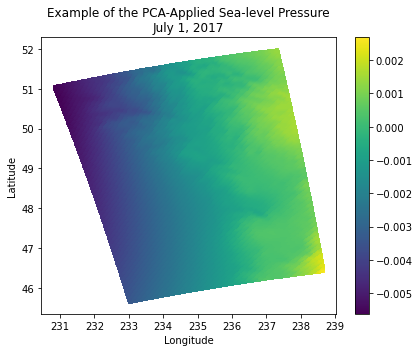

In [76]:
#visualize reconstruction - with actual PCs
plt.figure(figsize=(6,5))

plt.scatter(hrdps_lon, hrdps_lat,
            c = data_rec[547,:],
            cmap = 'viridis',
            s = 10,
            marker = 's')
plt.title('Example of the PCA-Applied Sea-level Pressure\nJuly 1, 2017')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar()

plt.tight_layout()